<a href="https://colab.research.google.com/github/khairnarpv/ML-Project/blob/main/india_Primary_helthcare_based_on_workforce_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **STEP 1: Upload ZIP**

In [ ]:
from google.colab import files
import zipfile
import os
import pandas as pd

In [ ]:
# Upload ZIP
uploaded = files.upload()

# Extract ZIP
zip_path = next(iter(uploaded))
extract_dir = "healthcare_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Locate CSV files inside the folder
data_dir = os.path.join(extract_dir, "HR Data")
files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

Saving Healthcare workfore data.zip to Healthcare workfore data.zip


## **STEP 2: Load Data and EDA**

In [ ]:
# Data cleaning function
def clean_healthcare_df(filepath, role_name):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    df = df.rename(columns={
        'State/ UT': 'State_UT',
        'Required - [R]': 'Required',
        'Sanctioned - [S]': 'Sanctioned',
        'In Position - [P]': 'In_Position',
        'Vacant - [S-P]': 'Vacant',
        'Shortfall - [R-P]': 'Shortfall'
    })
    df = df[['State_UT', 'Required', 'Sanctioned', 'In_Position', 'Vacant', 'Shortfall']]
    df['Role'] = role_name
    return df


In [ ]:
# Combine all data
dfs = []
for file in files:
    path = os.path.join(data_dir, file)
    role = file.replace('.csv', '').replace('_2017', '').replace('-', ' ').title()
    try:
        df = clean_healthcare_df(path, role)
        dfs.append(df)
    except Exception as e:
        print(f"Error in {file}: {e}")

combined_df = pd.concat(dfs, ignore_index=True)
combined_df.dropna(subset=["State_UT"], inplace=True)
combined_df.head()

,State_UT,Required,Sanctioned,In_Position,Vacant,Shortfall,Role
0,Andhra Pradesh,193,160.0,75.0,85.0,118.0,Radiographers Chcs
1,Arunachal Pradesh,63,NaN,7.0,NaN,56.0,Radiographers Chcs
2,Assam,158,145.0,60.0,85.0,98.0,Radiographers Chcs
3,Bihar,150,89.0,1.0,88.0,149.0,Radiographers Chcs
4,Chhattisgarh,169,162.0,130.0,32.0,39.0,Radiographers Chcs


In [ ]:
# Check where nulls are present
combined_df.isnull().sum()

,0
State_UT,0
Required,0
Sanctioned,33
In_Position,1
Vacant,92
Shortfall,100
Role,0


In [ ]:
# Convert to numeric (if not already), coercing errors to NaN
for col in ['Required', 'Sanctioned', 'In_Position', 'Vacant', 'Shortfall']:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Fill NaN values with 0 — safe for numerical shortage counts
combined_df[['Required', 'Sanctioned', 'In_Position', 'Vacant', 'Shortfall']] = \
    combined_df[['Required', 'Sanctioned', 'In_Position', 'Vacant', 'Shortfall']].fillna(0)

# Final check
combined_df.isnull().sum()


,0
State_UT,0
Required,0
Sanctioned,0
In_Position,0
Vacant,0
Shortfall,0
Role,0


## **STEP 3: Segment the Market**


### Segment 1: Demographic & Firmographic

In [ ]:
# Total workforce per state
state_stats = combined_df.groupby(['State_UT', 'Role'])['In_Position'].sum().unstack().fillna(0)
state_stats['Total_Workforce'] = state_stats.sum(axis=1)
state_stats.head()


Role,Allo Doc Phcs,Assistant Female Phcs,Assistant Male Phcs,Nursing Staff Phcs Chcs,Pharmacists Phcs Chcs,Physician Chcs,Radiographers Chcs,Surgeons Chcs,Worker Female Subcen,Worker Male Subcen,Total_Workforce
State_UT,,,,,,,,,,,
A & N Island,34.0,20.0,11.0,193.0,49.0,0.0,0.0,0.0,241.0,45.0,593.0
All India/ Total,27124.0,14267.0,12288.0,70738.0,25193.0,864.0,2129.0,758.0,198356.0,56263.0,407980.0
Andhra Pradesh,1644.0,1143.0,0.0,3541.0,994.0,56.0,75.0,38.0,12073.0,2964.0,22528.0
Arunachal Pradesh,122.0,6.0,81.0,498.0,89.0,1.0,7.0,0.0,323.0,92.0,1219.0
Assam,1048.0,308.0,106.0,2793.0,1384.0,31.0,60.0,12.0,7545.0,2783.0,16070.0


<ipython-input-9-8f4e6edc6723>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_stats_sorted['Total_Workforce'], y=state_stats_sorted.index, palette='viridis')


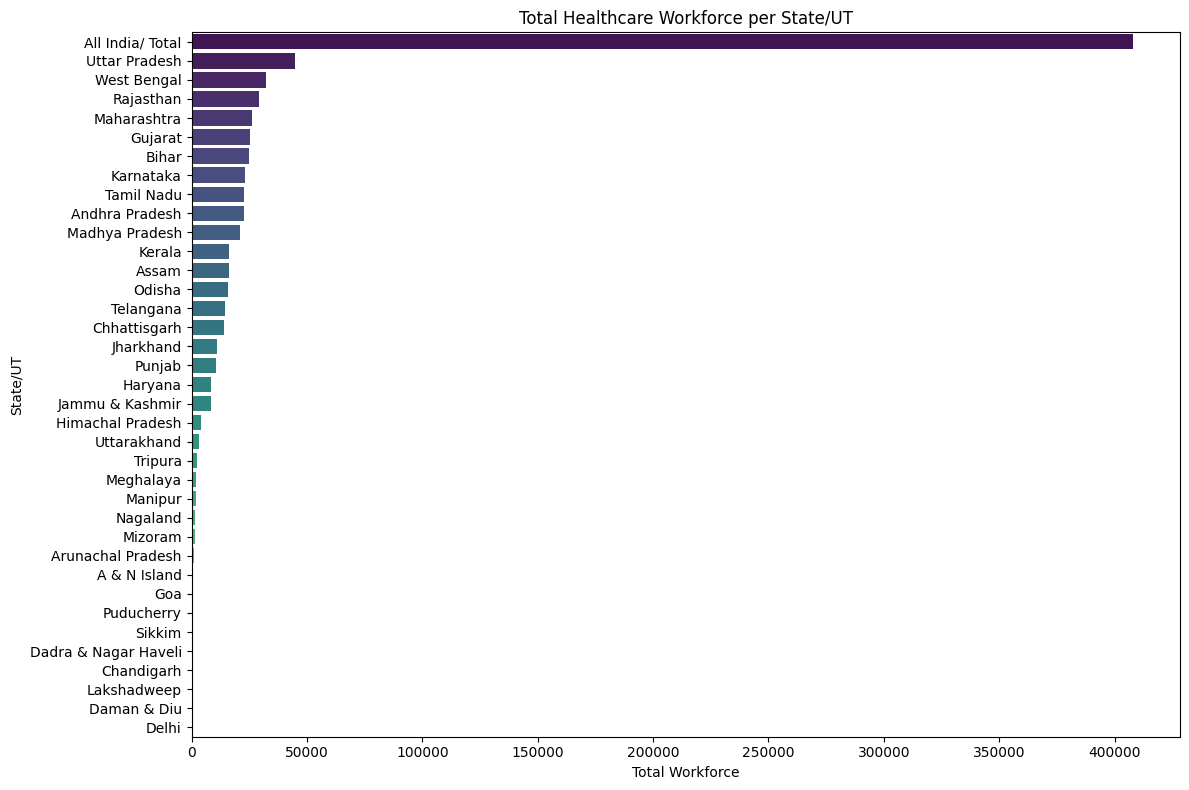

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort states by total workforce for better visualization
state_stats_sorted = state_stats.sort_values('Total_Workforce', ascending=False)

# Set plot style
plt.figure(figsize=(12, 8))
sns.barplot(x=state_stats_sorted['Total_Workforce'], y=state_stats_sorted.index, palette='viridis')

# Add labels and title
plt.xlabel('Total Workforce')
plt.ylabel('State/UT')
plt.title('Total Healthcare Workforce per State/UT')
plt.tight_layout()

# Show the plot
plt.show()


### Segment 2: Service/Role Distribution

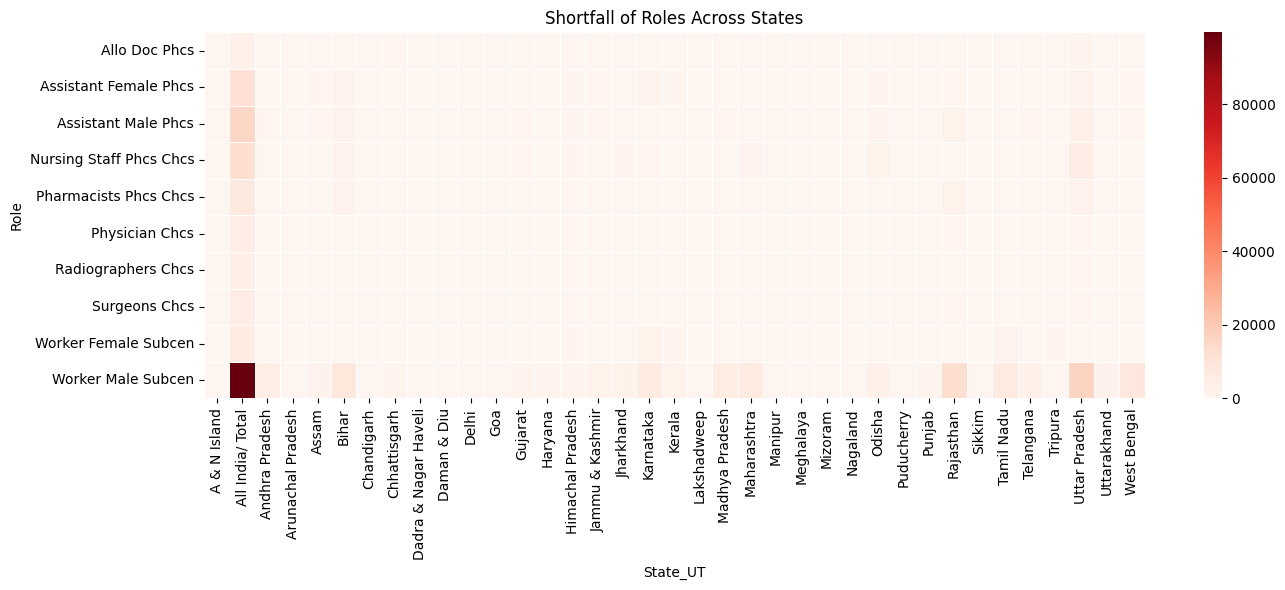

In [ ]:
# Heatmap of role shortfalls across states
import seaborn as sns
import matplotlib.pyplot as plt

role_shortfalls = combined_df.pivot_table(index='Role', columns='State_UT', values='Shortfall', aggfunc='sum').fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(role_shortfalls, cmap='Reds', linewidths=.5)
plt.title('Shortfall of Roles Across States')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<ipython-input-17-f5163710c833>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_shortfalls.index, y=state_shortfalls.values, palette='Reds')


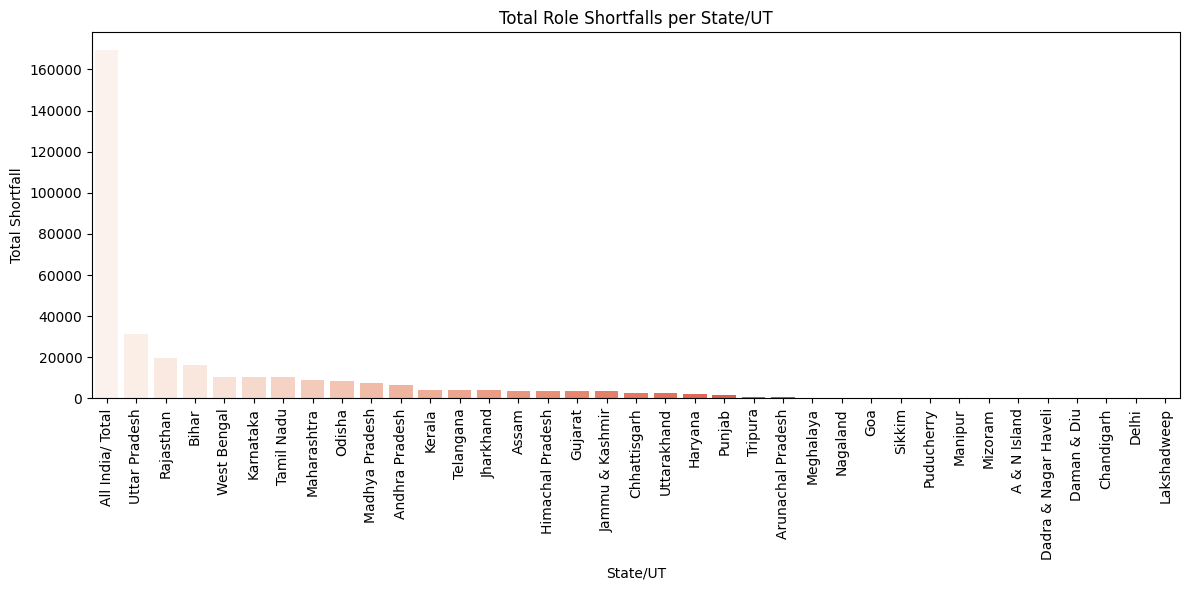

In [ ]:
# 1. Barplot: Total Shortfall per State
import matplotlib.pyplot as plt
import seaborn as sns

# Total shortfall per state
state_shortfalls = role_shortfalls.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=state_shortfalls.index, y=state_shortfalls.values, palette='Reds')
plt.xticks(rotation=90)
plt.ylabel('Total Shortfall')
plt.xlabel('State/UT')
plt.title('Total Role Shortfalls per State/UT')
plt.tight_layout()
plt.show()


<ipython-input-18-9c7dd1b71125>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_shortfalls_sum.values, y=role_shortfalls_sum.index, palette='Reds')


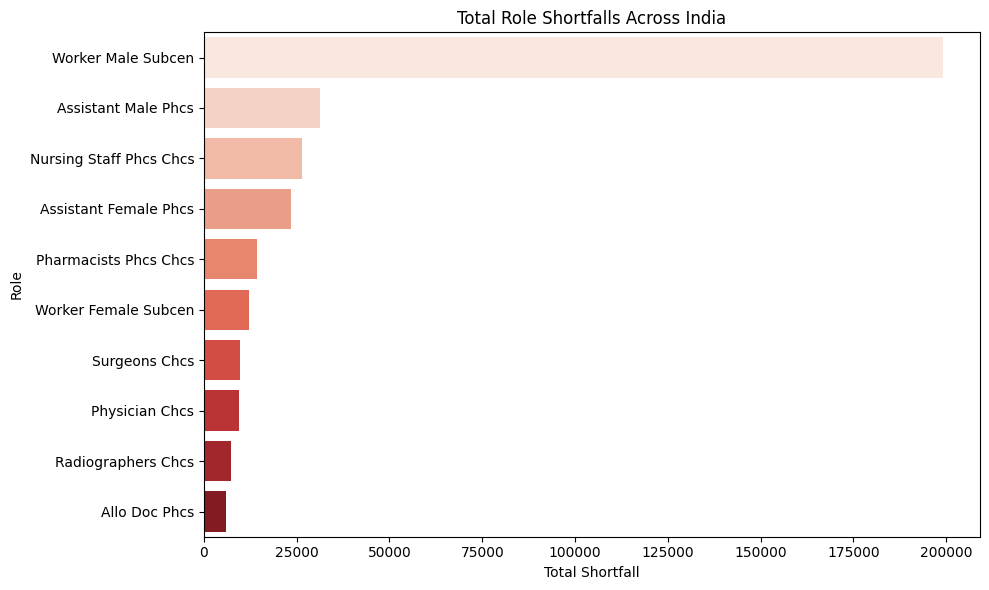

In [ ]:
# 2. Barplot: Total Shortfall per Role
# Total shortfall per role
role_shortfalls_sum = role_shortfalls.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=role_shortfalls_sum.values, y=role_shortfalls_sum.index, palette='Reds')
plt.xlabel('Total Shortfall')
plt.ylabel('Role')
plt.title('Total Role Shortfalls Across India')
plt.tight_layout()
plt.show()


### Segment 3: Financial & Economic (Vacancy Rates)

In [ ]:
combined_df['Vacancy_Rate'] = (combined_df['Sanctioned'] - combined_df['In_Position']) / combined_df['Sanctioned']
vacancy_rate = combined_df.groupby('State_UT')['Vacancy_Rate'].mean().sort_values(ascending=False)
vacancy_rate.head(10)


,Vacancy_Rate
State_UT,
Rajasthan,0.492908
Uttar Pradesh,0.450014
Mizoram,0.449043
Uttarakhand,0.438593
Madhya Pradesh,0.406281
West Bengal,0.383200
Haryana,0.379426
Gujarat,0.367909
Chhattisgarh,0.367776


<ipython-input-21-a938f954666c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vacancy_states.values, y=top_vacancy_states.index, palette='Oranges_r')


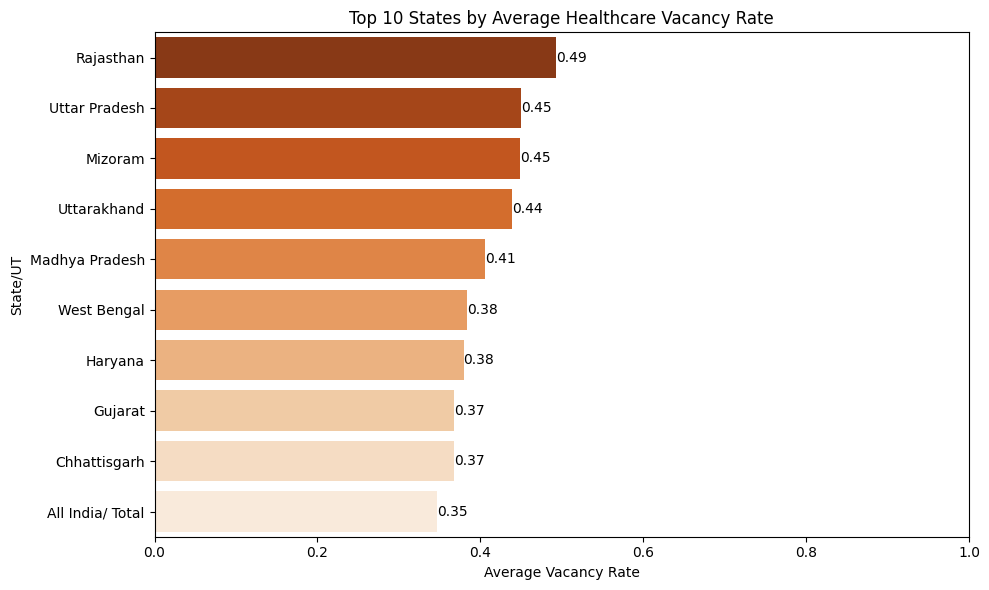

In [ ]:
# Plot top 10 states by average vacancy rate
top_vacancy_states = vacancy_rate.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_vacancy_states.values, y=top_vacancy_states.index, palette='Oranges_r')

# Add value labels
for index, value in enumerate(top_vacancy_states.values):
    plt.text(value, index, f"{value:.2f}", va='center')

# Labels and title
plt.xlabel('Average Vacancy Rate')
plt.ylabel('State/UT')
plt.title('Top 10 States by Average Healthcare Vacancy Rate')
plt.xlim(0, 1)  # Since vacancy rate is a fraction
plt.tight_layout()
plt.show()


### Segment 4: Tech Adoption (Proxy via low staffing)

In [ ]:
combined_df['Shortfall_Ratio'] = combined_df['Shortfall'] / (combined_df['Required'] + 1)
impact_df = combined_df.groupby('State_UT')['Shortfall_Ratio'].mean().sort_values(ascending=False)
impact_df.head(10)


,Shortfall_Ratio
State_UT,
Bihar,0.707821
Himachal Pradesh,0.619224
Uttar Pradesh,0.592583
Arunachal Pradesh,0.577100
Jharkhand,0.571058
Uttarakhand,0.540853
Odisha,0.528595
Rajasthan,0.524169
West Bengal,0.503957


<ipython-input-23-88370a46eb44>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_impact_states.values, y=top_impact_states.index, palette='flare')


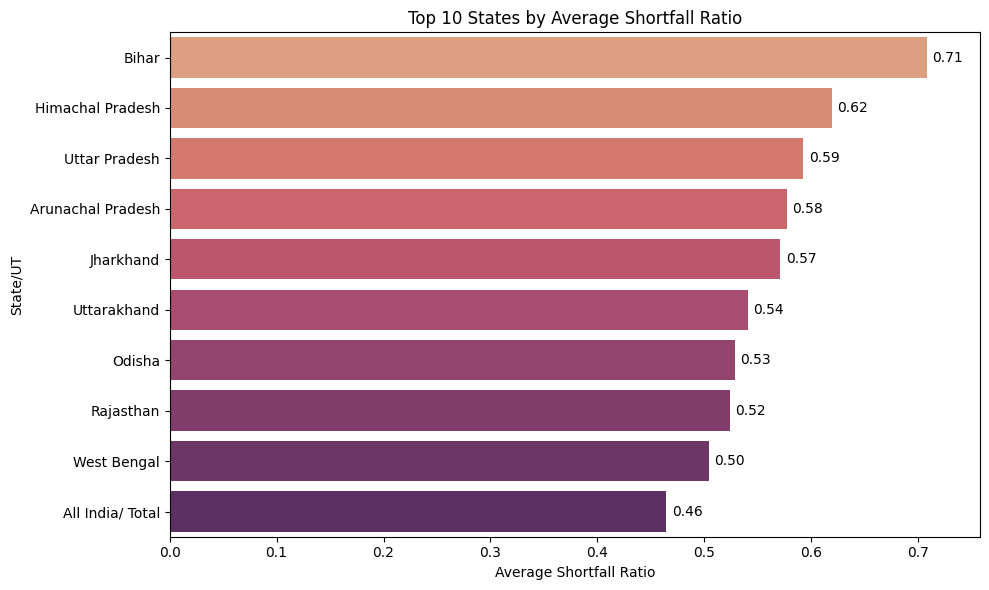

In [ ]:
# Select top 10 states by Shortfall Ratio
top_impact_states = impact_df.head(10)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_impact_states.values, y=top_impact_states.index, palette='flare')

# Annotate each bar with the Shortfall Ratio
for index, value in enumerate(top_impact_states.values):
    plt.text(value + 0.005, index, f"{value:.2f}", va='center')

# Labels and title
plt.xlabel('Average Shortfall Ratio')
plt.ylabel('State/UT')
plt.title('Top 10 States by Average Shortfall Ratio')
plt.xlim(0, top_impact_states.max() + 0.05)
plt.tight_layout()

# Show plot
plt.show()


### Segment 5: Market Need (Shortfall vs Required)

In [ ]:
state_level_summary = combined_df.groupby('State_UT').agg({
    'Required': 'sum',
    'Sanctioned': 'sum',
    'In_Position': 'sum',
    'Shortfall': 'sum'
})
state_level_summary['Shortfall_Rate'] = state_level_summary['Shortfall'] / (state_level_summary['Required'] + 1)
state_level_summary.sort_values('Shortfall_Rate', ascending=False).head(10)


,Required,Sanctioned,In_Position,Shortfall,Shortfall_Rate
State_UT,,,,,
Bihar,31043,8452.0,24939.0,16306.0,0.525254
Himachal Pradesh,7835,6668.0,4031.0,3804.0,0.485452
Uttarakhand,5639,3736.0,3047.0,2654.0,0.470567
Uttar Pradesh,68189,55553.0,44756.0,31162.0,0.456988
Rajasthan,45576,41951.0,29407.0,19651.0,0.431160
Arunachal Pradesh,2032,0.0,1219.0,824.0,0.405312
Tamil Nadu,28469,27998.0,22740.0,10556.0,0.370776
West Bengal,29147,43541.0,32375.0,10669.0,0.366029
Odisha,23846,16643.0,15987.0,8381.0,0.351449


<ipython-input-24-a99cfe6d2ed5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_shortfall_states['Shortfall_Rate'], y=top_shortfall_states.index, palette='magma')


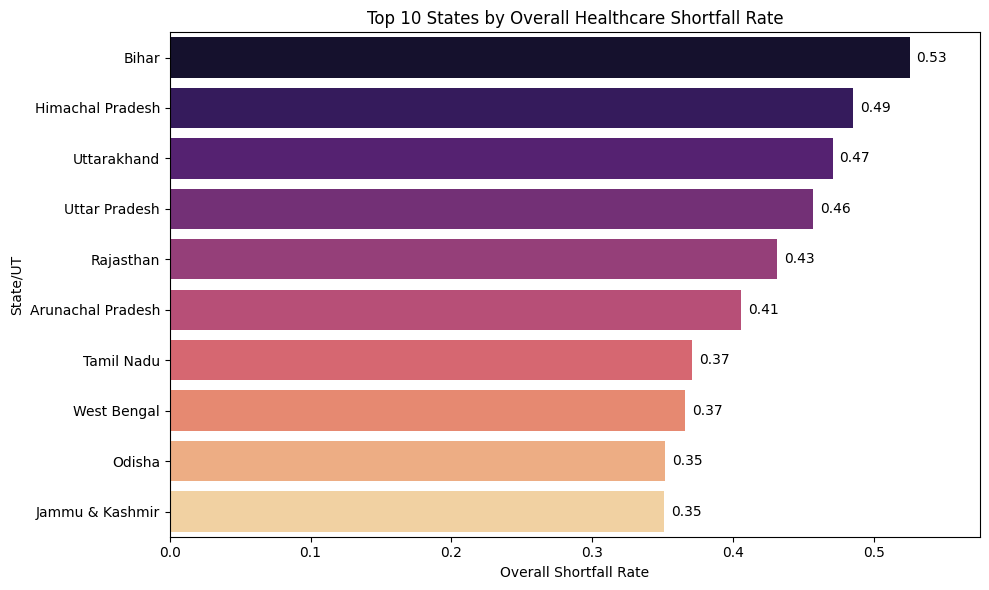

In [ ]:
# Sort and get top 10 states by Shortfall Rate
top_shortfall_states = state_level_summary.sort_values('Shortfall_Rate', ascending=False).head(10)

# Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_shortfall_states['Shortfall_Rate'], y=top_shortfall_states.index, palette='magma')

# Annotate bars
for index, value in enumerate(top_shortfall_states['Shortfall_Rate']):
    plt.text(value + 0.005, index, f"{value:.2f}", va='center')

# Labels and title
plt.xlabel('Overall Shortfall Rate')
plt.ylabel('State/UT')
plt.title('Top 10 States by Overall Healthcare Shortfall Rate')
plt.xlim(0, top_shortfall_states['Shortfall_Rate'].max() + 0.05)
plt.tight_layout()

# Show plot
plt.show()

## **STEP 4: Clustering (K-Means for Segmentation)**

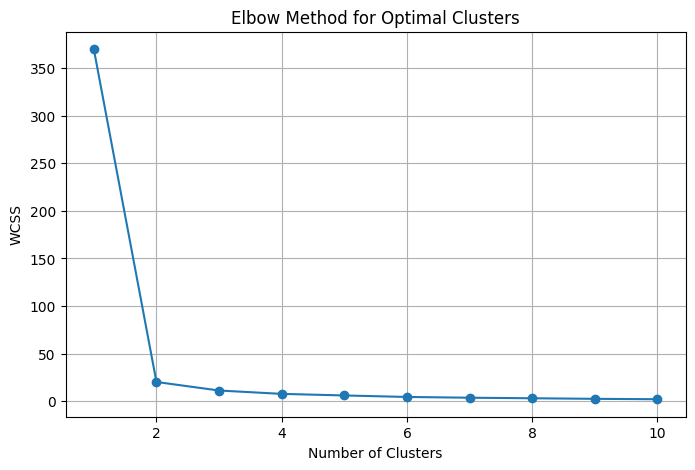

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Use role-wise in-position numbers for clustering
X = state_stats.drop(columns='Total_Workforce')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


Apply KMeans and Assign Clusters

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
state_stats['Cluster'] = kmeans.fit_predict(X_scaled)
state_stats.reset_index()[['State_UT', 'Cluster']].sort_values('Cluster')


Role,State_UT,Cluster
0,A & N Island,0
3,Arunachal Pradesh,0
5,Bihar,0
4,Assam,0
6,Chandigarh,0
7,Chhattisgarh,0
9,Daman & Diu,0
8,Dadra & Nagar Haveli,0
13,Haryana,0
14,Himachal Pradesh,0


## **STEP 5: Cluster Profile Analysis**

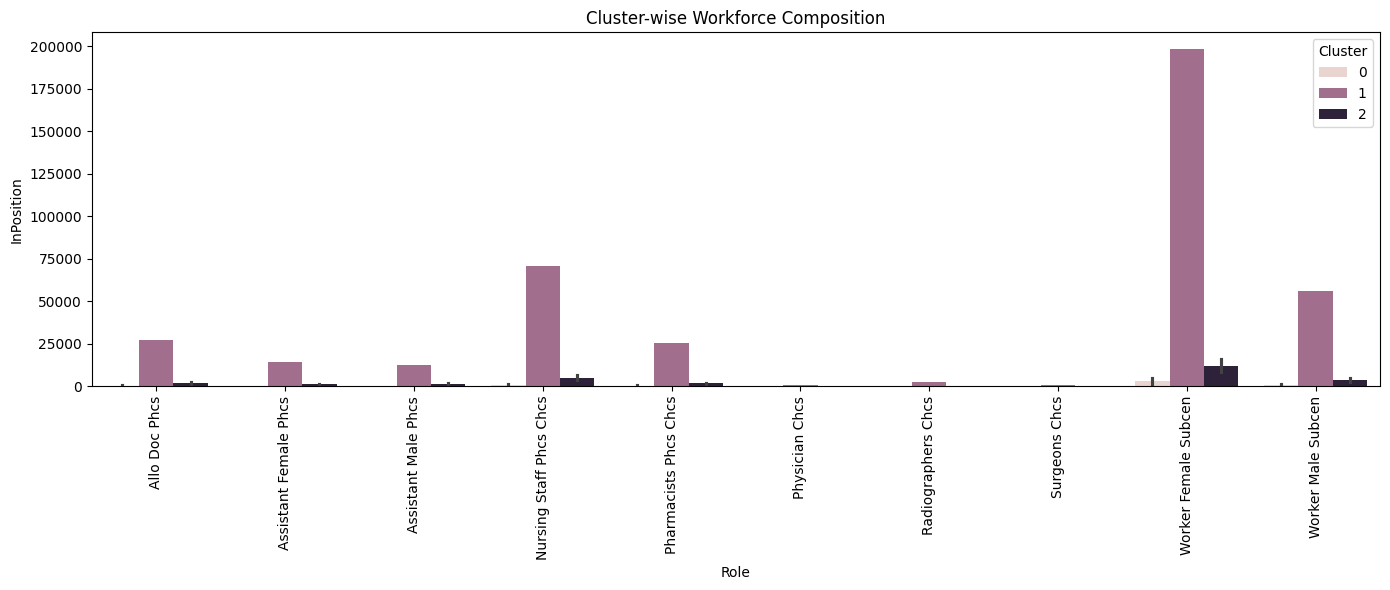

In [ ]:
# Melt for visual profile
state_stats_reset = state_stats.reset_index()
melt_df = state_stats_reset.melt(id_vars=['State_UT', 'Cluster'], var_name='Role', value_name='InPosition')
melt_df = melt_df[melt_df['Role'] != 'Total_Workforce']

plt.figure(figsize=(14,6))
sns.barplot(data=melt_df, x='Role', y='InPosition', hue='Cluster')
plt.title("Cluster-wise Workforce Composition")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
